# BN16 Data Insights

Playground for the bn16 dataset. Used for several visualizations and exploration of the dataset.

## Imports

In [1]:
#!TMPDIR=../../tmp pip install torch==1.5.* torchsummary==1.5.1 numpy pandas matplotlib sparse ipywidgets
# !TMPDIR=../../tmp pip install torch==1.5.* torch-summary numpy pandas matplotlib sparse ipywidgets
# !TMPDIR=../../tmp pip install networkx 

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchsummary import summary
import sparse
from torch.utils.data import Dataset, DataLoader, random_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from timeit import default_timer as timer
import datetime

from ipywidgets import interact, interactive
import ipywidgets

import networkx as nx

## Config

In [3]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(DEVICE)
RND_SEED = 1
BATCH_SIZE = 8
N_STEPS = 12
N_INDIVIDUALS = 2443

torch.random.manual_seed(RND_SEED)
torch.cuda.manual_seed(RND_SEED)

pd.options.display.max_rows = 20
pd.options.display.min_rows = None
pd.options.display.width = 800
np.set_printoptions(edgeitems=5)
np.core.arrayprint._line_width = 300

plt.rc('figure', titlesize=18)

cuda


# Data



The data has dimensions $I \times I \times D \times T$, with $I \times I$ being the individuals interactions matrix, $D$ being the day of observation and $T$ being the time of the snapshot (48 times half an hour). The actual dimensions are $2443 \times 2443 \times 56 \times 48$.

That means that we have sequences of length $56 \cdot 48 = 2688$ (in time). The life span of the individuals depends on their tasks and individual factors.

## File Chunking

Transform into daily chunks with dimensions: time x I x I where time is 48x half an hour and I is the individual.

## Additional Data

Data for downstream tasks like aliveness estimation, circadian rhythm and task allocation.

### Aliveness

Individuals were introduced to the hive at different time steps (days).

In [4]:
observation_start_date = datetime.datetime(2016, 7, 23, 0, 0, 0, 0)
hatching_start_date = datetime.datetime(2016, 7, 19, 0, 0, 0, 0)

In [5]:
indices_data = pd.read_csv('indices_bn16.csv').sort_values(by='bee_id')
alive_data = pd.read_csv('alive_bn16.csv').sort_values(by='bee_id').reset_index(drop=True) # required or the data will be messed up

In [6]:
# combine both
combined_alive_data = alive_data
combined_alive_data['interaction_matrix_idx'] = indices_data['interaction_matrix_idx']
# now sort by matrix id for easy vector generation
combined_alive_data = combined_alive_data.sort_values(by='interaction_matrix_idx')
# date column type fix
combined_alive_data['date_emerged'] = pd.to_datetime(combined_alive_data['date_emerged'])
# let's translate the hatch day into a step where observation_start_date is step 0
combined_alive_data['born_in_step'] = combined_alive_data['date_emerged'].map(lambda x: (x - observation_start_date).days * 48)
combined_alive_data['dead_by_step'] = combined_alive_data.apply(lambda row: 48 * row['days_alive'] + row['born_in_step'], axis=1)
# combined_alive_data = get_combined_alive_data(indices_data, alive_data, observation_start_date)
combined_alive_data

,bee_id,date_emerged,days_alive,interaction_matrix_idx,born_in_step,dead_by_step
0,9,2016-07-19,5,0,-192,48
1,10,2016-07-19,16,1,-192,576
2,17,2016-07-19,4,2,-192,0
3,21,2016-07-19,35,3,-192,1488
4,22,2016-07-19,19,4,-192,720
5,37,2016-07-19,15,5,-192,528
6,38,2016-07-19,8,6,-192,192
7,39,2016-08-01,24,7,432,1584
8,40,2016-07-19,14,8,-192,480
9,43,2016-07-19,18,9,-192,672


In [7]:
combined_alive_data['days_alive'].min(), combined_alive_data['days_alive'].max()

(0, 60)

In [8]:
combined_alive_data[combined_alive_data['days_alive'] == 0]

,bee_id,date_emerged,days_alive,interaction_matrix_idx,born_in_step,dead_by_step
123,360,2016-07-19,0,123,-192,-192
127,377,2016-07-19,0,127,-192,-192
135,403,2016-07-19,0,135,-192,-192
290,718,2016-07-19,0,290,-192,-192
309,759,2016-07-19,0,309,-192,-192
325,802,2016-07-19,0,325,-192,-192
326,803,2016-07-19,0,326,-192,-192
355,851,2016-07-19,0,355,-192,-192
435,996,2016-07-19,0,435,-192,-192
445,1012,2016-07-19,0,445,-192,-192


In [9]:
combined_alive_data[combined_alive_data['days_alive'] == 60]

,bee_id,date_emerged,days_alive,interaction_matrix_idx,born_in_step,dead_by_step
1054,1744,2016-07-21,60,1054,-96,2784


##### Age Distribution

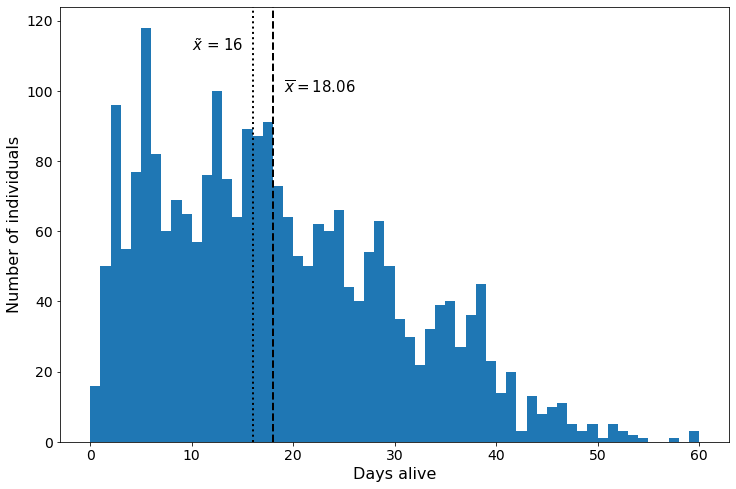

In [10]:
ax = combined_alive_data['days_alive'].plot.hist(bins=60, figsize=(12,8)) #,title='Age distribution of BN16'
ax.set_xlabel('Days alive', fontsize=16)
ax.set_ylabel('Number of individuals', fontsize=16)
ax.title.set_size(20)
mean = combined_alive_data['days_alive'].mean()
median = combined_alive_data['days_alive'].median()
min_ylim, max_ylim = plt.ylim()
plt.axvline(mean, color='k', linestyle='dashed', linewidth=2)
plt.text(mean + 1, max_ylim * 0.8, r'$\overline{x} = ' + '{:.2f}$'.format(mean), fontsize=15)
plt.axvline(median, color='k', linestyle='dotted', linewidth=2)
plt.text(median - 6, max_ylim * 0.9, r'$\tilde{x}$ = ' + '{:.0f}'.format(median), fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.show()

In [11]:
combined_alive_data['days_alive'].mean(), combined_alive_data['days_alive'].median()

(18.057715923045436, 16.0)

##### Birthday distribution

-4.0 31.0 5.0560785918952105 2.0


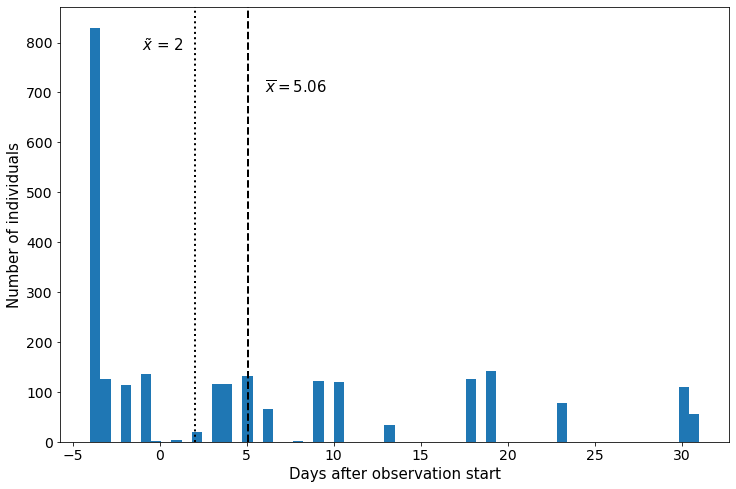

In [12]:
mean = combined_alive_data['born_in_step'].mean() / 48
median = combined_alive_data['born_in_step'].median() / 48
print(combined_alive_data['born_in_step'].min() / 48, combined_alive_data['born_in_step'].max()/ 48, mean, median)
ax = (combined_alive_data['born_in_step'] / 48).plot.hist(bins=60, figsize=(12,8)) # , title='Birthdate distribution'
ax.set_xlabel('Days after observation start', fontsize=15)
ax.set_ylabel('Number of individuals', fontsize=15)
ax.title.set_size(20)
min_ylim, max_ylim = plt.ylim()
plt.axvline(mean, color='k', linestyle='dashed', linewidth=2)
plt.text(mean + 1, max_ylim * 0.8, r'$\overline{x} = ' + '{:.2f}$'.format(mean), fontsize=15)
plt.axvline(median, color='k', linestyle='dotted', linewidth=2)
plt.text(median - 3, max_ylim * 0.9, r'$\tilde{x}$ = ' + '{:.0f}'.format(median), fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.show()

##### Util

Utility functions for transformation.

In [10]:
def bee_id_to_matrix_id(bee_id, index_data):
    '''Translates the bee ID into the matrix ID.'''
    return indices_data[indices_data['bee_id'] == bee_id]['interaction_matrix_idx'].item()

def matrix_id_to_bee_id(matrix_id):
    '''Translates the matrix ID into the bee ID.'''
    return indices_data[indices_data['interaction_matrix_idx'] == matrix_id]['bee_id'].item()

def get_aliveness_vector(step):
    '''Returns a #individuals-long boolean vector of matrix-ID-indexed bee aliveness.'''
    return (combined_alive_data['born_in_step'] <= step) & (step < combined_alive_data['dead_by_step'])

def get_lifespan_for_row(row, step):
    if ((step < row['born_in_step']) | (row['dead_by_step'] < step)): #iloc[0] if you pass in a df
        return 0
    return row['dead_by_step'] - step  #iloc[0] if you pass in a df    

def get_lifespan_vector(step):
    '''Returns a #individuals-long vector of matrix-ID-indexed remaining bee lifespans in steps (half an hour).'''
    return combined_alive_data.apply(get_lifespan_for_row, axis=1, step=step)

def get_lifespan_for_individual(midx):
    '''Get the remaining steps to live for given individual matrix index.'''
    # start at zero, not before
    bis = max(combined_alive_data[combined_alive_data['interaction_matrix_idx'] == midx]['born_in_step'].item(), 0)
    dis = combined_alive_data.iloc[midx]['dead_by_step']
    # full range, 56 days à 48 steps
    r = np.zeros(56 * 48) 
    # dead in 4 steps => 4,3,2,1 - clip to length
    ins = np.arange(dis - bis)[::-1][:len(r) - bis] 
    r[bis:bis + len(ins)] = ins
    return r

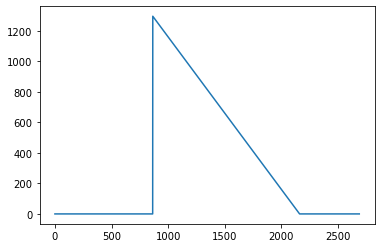

In [14]:
plt.plot(get_lifespan_for_individual(2002))
#combined_alive_data.iloc[2000]

In [15]:
%matplotlib inline
#@interact(x=ipywidgets.IntSlider(min=-0, max=48, step=1, value=0))
def individual_slider(x):
    fig = plt.figure(figsize=(6, 6))
    plt.plot(get_lifespan_for_individual(x))
    plt.show()
interactive_plot = interactive(individual_slider, x=ipywidgets.IntSlider(min=0, max=2442, step=1, value=0, continuous_update=False))
output = interactive_plot.children[-1]
output.layout.height = '370px'
interactive_plot

interactive(children=(IntSlider(value=0, continuous_update=False, description='x', max=2442), Output(layout=La…

#### Aliveness Distribution

In [10]:
num_alive = pd.DataFrame([np.count_nonzero(get_lifespan_vector(i * 48)) for i in range(56)]) # daily

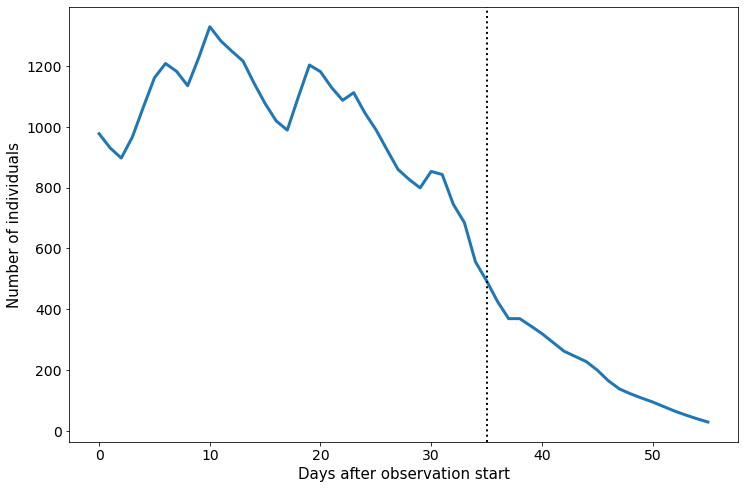

In [17]:
ax = num_alive.plot(figsize=(12,8), linewidth=3, legend=False) # , title='Number of living individuals over time'
ax.set_xlabel('Days after observation start', fontsize=15)
ax.set_ylabel('Number of individuals', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.axvline(35, color='k', linestyle='dotted', linewidth=2)
ax.title.set_size(20)

### Circadian rhythm

In [11]:
circadian = pd.read_csv(
    'rhythmicity_bn16.csv',
    dtype={'bee_id': np.int16, 'age': np.int8, 'date': str, 'circadian_rhythmicity': np.float64},
    parse_dates=['date'],
    date_parser = pd.to_datetime
)
circadian[0:5]

,bee_id,age,date,circadian_rhythmicity
0,960,7,2016-07-26,0.025426
1,1126,7,2016-07-26,0.022645
2,1519,6,2016-07-26,0.002309
3,1527,7,2016-07-26,0.002183
4,1529,7,2016-07-26,0.009352


In [15]:
circadian[circadian['bee_id'] == 960]

,bee_id,age,date,circadian_rhythmicity
0,960,7,2016-07-26,0.025426
236,960,8,2016-07-27,0.057799
1129,960,9,2016-07-28,0.039620
2290,960,10,2016-07-29,0.027402
3495,960,11,2016-07-30,0.025332
4676,960,12,2016-07-31,0.068931
5813,960,13,2016-08-01,0.103159
7042,960,14,2016-08-02,0.125147
8371,960,15,2016-08-03,0.142786
9667,960,16,2016-08-04,0.125677


In [16]:
(circadian.iloc[0].date - observation_start_date).days

3

In [17]:
circadian[-5:]

,bee_id,age,date,circadian_rhythmicity
37368,3204,24,2016-09-16,0.054921
37369,3230,24,2016-09-16,0.036922
37370,3235,24,2016-09-16,0.062644
37371,3259,24,2016-09-16,0.014456
37372,3260,24,2016-09-16,0.115805


In [12]:
# we need to expand the days into 48 copies, also, we don't know if there are gaps in the date so we should not rely on the date to be continous
def circadian_vector_for_individual(bee_id, circadian, observation_start_date):
    v = np.zeros(56 * 48)
    for row in circadian[circadian['bee_id'] == bee_id].itertuples():
        ins_start = (row.date - observation_start_date).days * 48
        v[ins_start:ins_start + 48] = np.repeat(row.circadian_rhythmicity, 48)
    return v

In [19]:
a = circadian_vector_for_individual(960, circadian, observation_start_date)
a[140:630]

array([0.        , 0.        , 0.        , 0.        , 0.02542618,
       0.02542618, 0.02542618, 0.02542618, 0.02542618, 0.02542618,
       0.02542618, 0.02542618, 0.02542618, 0.02542618, 0.02542618,
       0.02542618, 0.02542618, 0.02542618, 0.02542618, 0.02542618,
       0.02542618, 0.02542618, 0.02542618, 0.02542618, 0.02542618,
       0.02542618, 0.02542618, 0.02542618, 0.02542618, 0.02542618,
       0.02542618, 0.02542618, 0.02542618, 0.02542618, 0.02542618,
       0.02542618, 0.02542618, 0.02542618, 0.02542618, 0.02542618,
       0.02542618, 0.02542618, 0.02542618, 0.02542618, 0.02542618,
       0.02542618, 0.02542618, 0.02542618, 0.02542618, 0.02542618,
       0.02542618, 0.02542618, 0.05779903, 0.05779903, 0.05779903,
       0.05779903, 0.05779903, 0.05779903, 0.05779903, 0.05779903,
       0.05779903, 0.05779903, 0.05779903, 0.05779903, 0.05779903,
       0.05779903, 0.05779903, 0.05779903, 0.05779903, 0.05779903,
       0.05779903, 0.05779903, 0.05779903, 0.05779903, 0.05779

In [24]:
%matplotlib inline
#@interact(x=ipywidgets.IntSlider(min=-0, max=48, step=1, value=0))
def individual_slider(x):
    fig = plt.figure(figsize=(6, 6))
    plt.plot(circadian_vector_for_individual(matrix_id_to_bee_id(x), circadian, observation_start_date))
    plt.show()
interactive_plot = interactive(individual_slider, x=ipywidgets.IntSlider(min=0, max=2442, step=1, value=0, continuous_update=False))
output = interactive_plot.children[-1]
output.layout.height = '370px'
interactive_plot

interactive(children=(IntSlider(value=0, continuous_update=False, description='x', max=2442), Output(layout=La…

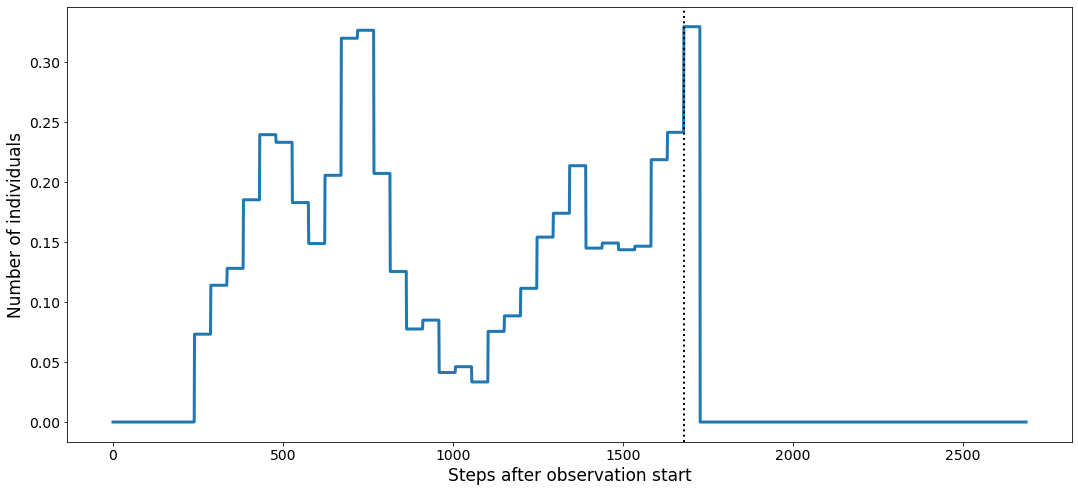

In [25]:
#circadian[circadian['bee_id'] == matrix_id_to_bee_id(1645)]['circadian_rhythmicity'].plot()
fig, ax = plt.subplots(1, 1, figsize=(18, 8))
ax.plot(circadian_vector_for_individual(matrix_id_to_bee_id(394), circadian, observation_start_date), linewidth=3)
ax.set_xlabel('Steps after observation start', fontsize=17)
ax.set_ylabel('Number of individuals', fontsize=17)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.axvline(35 * 48, color='k', linestyle='dotted', linewidth=2)
plt.show()

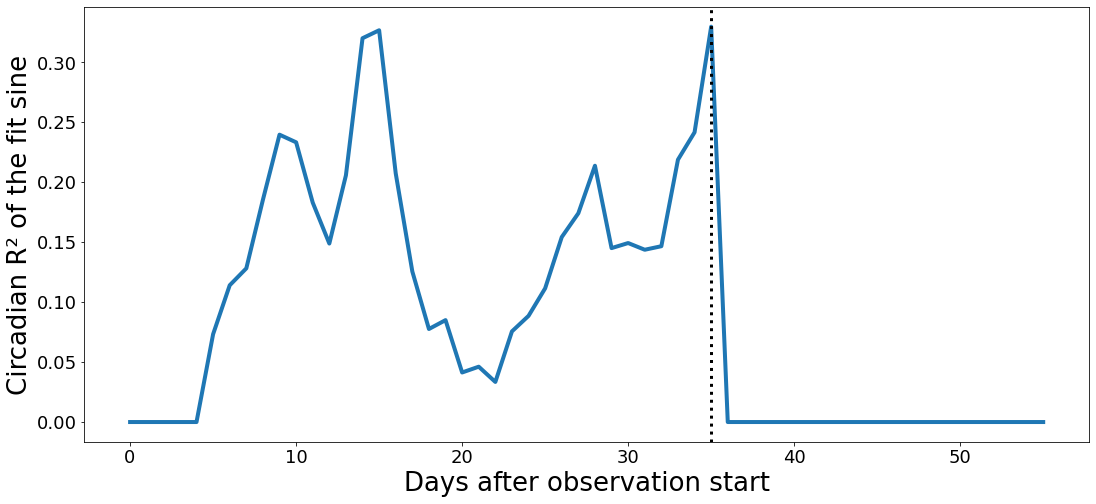

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(18, 8))
ax.plot(circadian_vector_for_individual(matrix_id_to_bee_id(394), circadian, observation_start_date).reshape((56, 48)).mean(axis=1), linewidth=4)
ax.set_xlabel('Days after observation start', fontsize=26)
ax.set_ylabel('Circadian R² of the fit sine', fontsize=26)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.axvline(35, color='k', linestyle='dotted', linewidth=3)
ax.title.set_size(20)
plt.show()

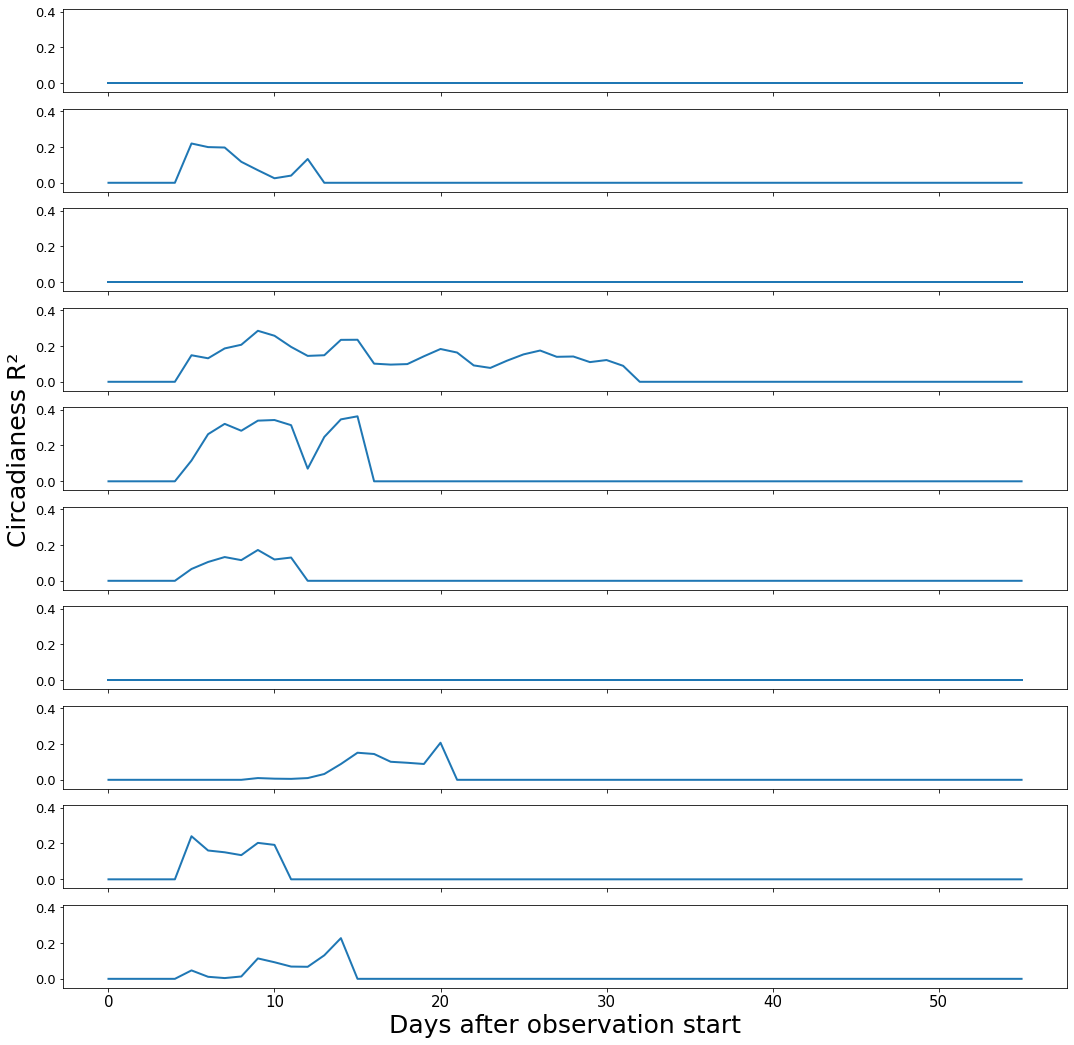

In [27]:
fig, axes = plt.subplots(10, 1, figsize=(18, 18))
v = [circadian_vector_for_individual(matrix_id_to_bee_id(i), circadian, observation_start_date).reshape((56, 48)).mean(axis=1) for i in range(len(axes))]
vmin = np.array([x.min() for x in v]).min() - .05
vmax = np.array([x.max() for x in v]).max() + .05
for i in range(len(axes)):
    im = axes[i].plot(v[i], linewidth=2)
    axes[i].set_ylim(vmin, vmax)
    #axes[i].tick_params(labelcolor='none', bottom=False, left=False, labelbottom=False, labelleft=False)
    axes[i].tick_params(left=True, labelbottom=False, labelleft=True, labelsize=13)
axes[-1].tick_params(axis='both', bottom=True, labelbottom=True, labelcolor='black')
axes[-1].set_xlabel('Days after observation start', fontsize=25)
axes[4].set_ylabel('Circadianess R²', fontsize=25)
axes[-1].tick_params(axis='x', which='major', labelsize=15)
plt.show()

In [28]:
circadian['circadian_rhythmicity'].min(), circadian['circadian_rhythmicity'].max(), circadian['circadian_rhythmicity'].mean()

(-1.8785975e-09, 0.46728662, 0.0783725138975603)

### Task allocation

In [49]:
tasks = pd.read_csv(
    'time_spent_on_substrates.csv',
    dtype={
        'bee_id': np.int16,
        'age': np.int8,
        'date': str,
    },
    parse_dates=['date'],
    date_parser = pd.to_datetime,
    usecols=['bee_id', 'age', 'date', 'brood_area_total', 'dance_floor', 'honey_storage', 'near_exit', 'location_descriptor_count']
)
tasks[0:5]

,bee_id,age,date,brood_area_total,dance_floor,honey_storage,near_exit,location_descriptor_count
0,10,34,2016-08-01,0.000000,0.235669,0.019108,0.745223,157.0
1,21,34,2016-08-01,0.002825,0.183616,0.008475,0.805085,354.0
2,22,34,2016-08-01,0.000000,0.586207,0.005747,0.408046,174.0
3,37,34,2016-08-01,0.000000,0.306452,0.000000,0.693548,124.0
4,39,34,2016-08-01,0.866667,0.000000,0.133333,0.000000,60.0


In [79]:
tasks['max_task'] = tasks[['brood_area_total', 'dance_floor', 'honey_storage', 'near_exit']].idxmax(axis=1).astype('category')

In [99]:
tasks['max_task_codes'] = pd.Categorical(tasks['max_task']).codes

In [100]:
tasks[tasks['bee_id'] == 39]

,bee_id,age,date,brood_area_total,dance_floor,honey_storage,near_exit,location_descriptor_count,max_task,max_task_codes
4,39,34,2016-08-01,0.866667,0.000000,0.133333,0.000000,60.0,brood_area_total,0
1262,39,35,2016-08-02,0.608696,0.000000,0.391304,0.000000,115.0,brood_area_total,0
2607,39,36,2016-08-03,0.613445,0.042017,0.327731,0.016807,119.0,brood_area_total,0
3927,39,37,2016-08-04,0.318182,0.009091,0.654545,0.018182,110.0,honey_storage,2
5202,39,38,2016-08-05,0.455782,0.006803,0.510204,0.027211,147.0,honey_storage,2
6470,39,39,2016-08-06,0.377049,0.344262,0.114754,0.163934,61.0,brood_area_total,0
7676,39,40,2016-08-07,0.202381,0.404762,0.226190,0.166667,84.0,dance_floor,1
8801,39,41,2016-08-08,0.376812,0.014493,0.101449,0.507246,69.0,near_exit,3
9870,39,42,2016-08-09,0.307692,0.076923,0.384615,0.230769,26.0,honey_storage,2
10885,39,43,2016-08-10,0.250000,0.250000,0.250000,0.250000,4.0,brood_area_total,0


In [113]:
def get_task_labels_for(bee_id):
    # 0 brood, 1 dance, 2 honey, 3 exit
    v = np.zeros(35) - 1
    for row in tasks[tasks['bee_id'] == bee_id].itertuples():
        ins = (row.date - observation_start_date).days
        v[ins] = row.max_task_codes
    return v

In [139]:
get_task_labels_for(matrix_id_to_bee_id(1171))

array([-1., -1., -1., -1., -1., -1., -1., -1., -1.,  2.,  3.,  0.,  3.,
        3.,  0.,  3.,  0.,  0.,  0.,  3.,  0.,  3.,  1.,  3.,  3.,  3.,
        3.,  3.,  3.,  3.,  3.,  3.,  1.,  0., -1.])

In [150]:
# matrix_id_to_bee_id(1171) # 1880
# observation_start_date # 2016,7,23
tasks[tasks['bee_id'] == 1880] # first entry 2016,8,1
# circadian[circadian['bee_id'] == 1880] # first entry 2016,7,26
# combined_alive_data[combined_alive_data['bee_id'] == 1880] # hatch date 2016,22

,bee_id,age,date,brood_area_total,dance_floor,honey_storage,near_exit,location_descriptor_count,max_task,max_task_codes
689,1880,10,2016-08-01,0.205128,0.222222,0.564103,0.008547,117.0,honey_storage,2
1922,1880,11,2016-08-02,0.182609,0.078261,0.330435,0.408696,115.0,near_exit,3
3248,1880,12,2016-08-03,0.691275,0.120805,0.127517,0.060403,149.0,brood_area_total,0
4537,1880,13,2016-08-04,0.192308,0.160256,0.134615,0.512821,156.0,near_exit,3
5789,1880,14,2016-08-05,0.263359,0.053435,0.015267,0.667939,262.0,near_exit,3
7025,1880,15,2016-08-06,0.866667,0.009524,0.095238,0.028571,105.0,brood_area_total,0
8195,1880,16,2016-08-07,0.397959,0.122449,0.015306,0.464286,196.0,near_exit,3
9294,1880,17,2016-08-08,0.558282,0.202454,0.128834,0.110429,163.0,brood_area_total,0
10341,1880,18,2016-08-09,0.409639,0.204819,0.012048,0.373494,83.0,brood_area_total,0
11335,1880,19,2016-08-10,0.590476,0.314286,0.000000,0.095238,105.0,brood_area_total,0


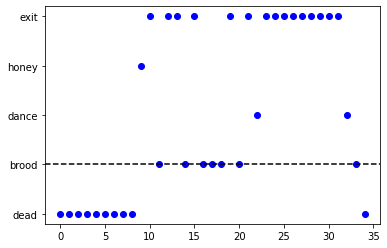

In [157]:
plt.plot(get_task_labels_for(1880), 'bo')
plt.axhline(y=0, color='black', linestyle='--')
plt.yticks([-1, 0, 1, 2, 3], ['dead', 'brood', 'dance', 'honey', 'exit'])
plt.show()

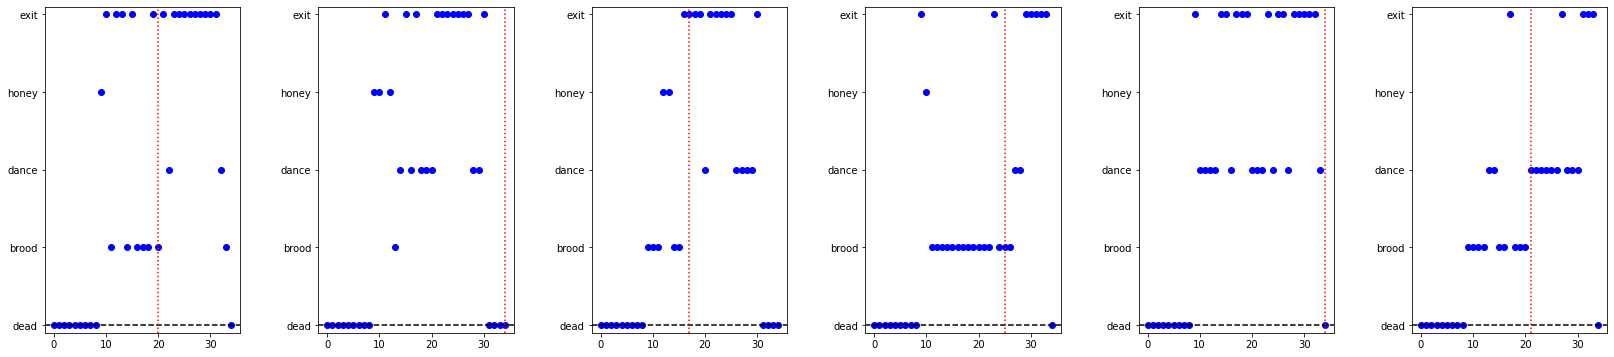

In [195]:
# most similar
# 1171, 558, 1525, 1158,  462, 1501
indvs = [1171, 558, 1525, 1158,  462, 1501]
days = [20, 34, 17, 25, 34, 21]
fig, axes = plt.subplots(1, 6, figsize=(28, 6))
for i in range(len(indvs)):
    ax = axes[i]
    indv = indvs[i]
    ax.plot(get_task_labels_for(matrix_id_to_bee_id(indv)), 'bo')
    ax.axhline(y=-1, color='black', linestyle='--')
    ax.axvline(days[i], color='red', linestyle=':')
    ax.set_ylim([-1.1,3.1])
    ax.set_yticks(list(range(-1,4)))
    ax.set_yticklabels(['dead', 'brood', 'dance', 'honey', 'exit'])
plt.subplots_adjust(wspace=.4)
plt.show()

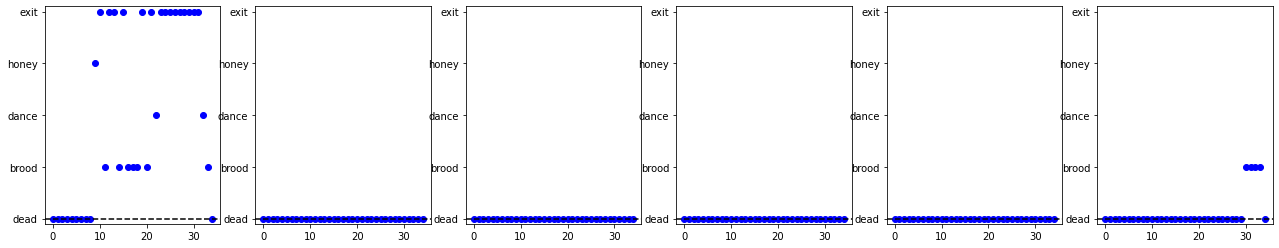

In [171]:
# least similar
indvs = [1171, 81,  559, 1040,  219, 2331]
fig, axes = plt.subplots(1, 6, figsize=(22, 4))
for i in range(len(indvs)):
    ax = axes[i]
    indv = indvs[i]
    ax.plot(get_task_labels_for(matrix_id_to_bee_id(indv)), 'bo')
    ax.axhline(y=-1, color='black', linestyle='--')
    ax.set_ylim([-1.1,3.1])
    ax.set_yticks(list(range(-1,4)))
    ax.set_yticklabels(['dead', 'brood', 'dance', 'honey', 'exit'])
plt.show()

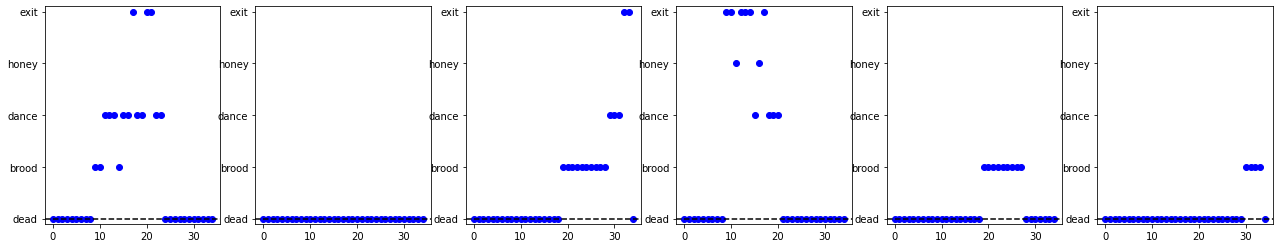

In [188]:
# random sample
indvs = np.random.randint(0,2444, size=6)
fig, axes = plt.subplots(1, 6, figsize=(22, 4))
for i in range(len(indvs)):
    ax = axes[i]
    indv = indvs[i]
    ax.plot(get_task_labels_for(matrix_id_to_bee_id(indv)), 'bo')
    ax.axhline(y=-1, color='black', linestyle='--')
    ax.set_ylim([-1.1,3.1])
    ax.set_yticks(list(range(-1,4)))
    ax.set_yticklabels(['dead', 'brood', 'dance', 'honey', 'exit'])
plt.show()

## Data Set

Datasets to be used by torch's data loader.

In [13]:
class OneDayDataSet(Dataset):
    '''Holds one complete day of the network.'''
    def __init__(self, day, transform=None):
        self.data = sparse.load_npz('daily/{}.npz'.format(day))
        self.transform = transform
        
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        d = torch.from_numpy(self.data[idx].todense())
        if self.transform:
            d = self.transform(d)
        return d

In [14]:
class IndividualDataSet(Dataset):
    '''Holds the data for one individual.'''
    def __init__(self, day, transform=None):
        self.data = sparse.load_npz('individuals/{}.npz'.format(day))
        self.transform = transform
        
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        d = torch.from_numpy(self.data[idx].todense())
        if self.transform:
            d = self.transform(d)
        return d

In [15]:
class Bn16DataSet(Dataset):
    def __init__(self, days=(0, 56), transform=None):
        self.days = days
        self.transform = transform
        
    def __len__(self):
        return 2443
    
    def __getitem__(self, idx):        
        d = sparse.load_npz('individuals/{}.npz'.format(idx))
        d = d[self.days[0] * 48:self.days[1] * 48]
        d = torch.from_numpy(d.todense().astype(np.float32))
        if self.transform:
            d = self.transform(d)
        return (d, {'lifespan': get_lifespan_for_individual(idx).astype('float')})

### Daily hive view

In [16]:
day_0_set = OneDayDataSet(0)
print(len(day_0_set))
day_0_set.data.shape

48


(48, 2443, 2443)

In [67]:
day_0_set.data[0].todense().astype(np.float32)[4].sum()

209.8623

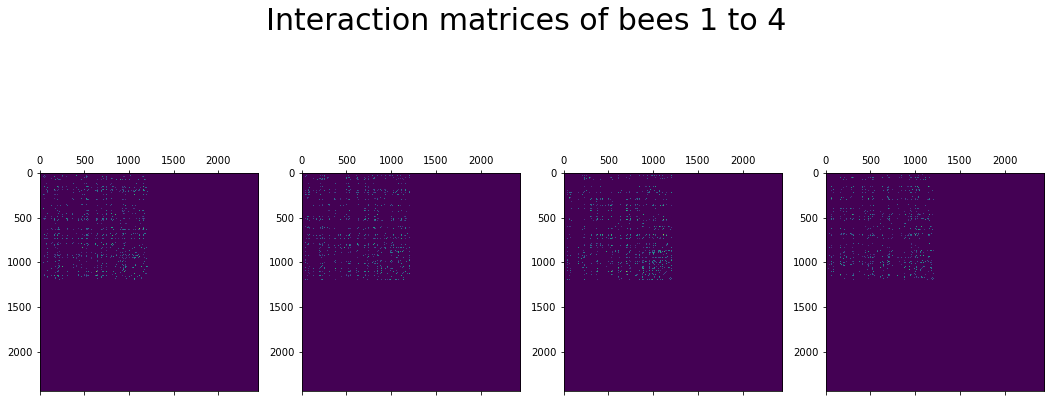

In [103]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(18, 8))
ax1.matshow(day_0_set.data[0].todense().astype(np.float32))
ax2.matshow(day_0_set.data[1].todense().astype(np.float32))
ax3.matshow(day_0_set.data[2].todense().astype(np.float32))
ax4.matshow(day_0_set.data[3].todense().astype(np.float32))
fig.suptitle('Interaction matrices of bees 1 to 4', fontsize=30)
plt.show()

Graph over the first day in 30-minute slices:

In [104]:
%matplotlib inline
#@interact(x=ipywidgets.IntSlider(min=-0, max=48, step=1, value=0))
def time_slider(x):
    fig = plt.figure(figsize=(6, 6))
    plt.matshow(day_0_set.data[x].todense().astype(np.float32)[:1500,:1500], fignum=1)
    plt.show()
interactive_plot = interactive(time_slider, x=ipywidgets.IntSlider(min=-0, max=47, step=1, value=0, continuous_update=False))
output = interactive_plot.children[-1]
output.layout.height = '370px'
interactive_plot

interactive(children=(IntSlider(value=0, continuous_update=False, description='x', max=47), Output(layout=Layo…

Accumulated graph over the first day:

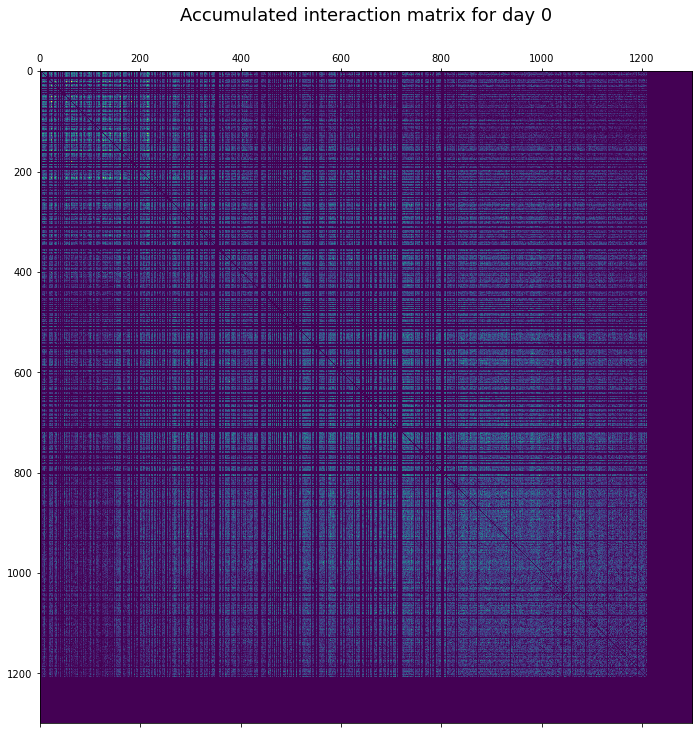

In [117]:
fig, ax = plt.subplots(figsize=(12, 12))
ax.matshow(torch.Tensor(day_0_set.data.todense().astype(np.float32)).sum(0)[:1300,:1300])
ax.set_title('Accumulated interaction matrix for day 0', fontsize=18, pad=50)
plt.show()

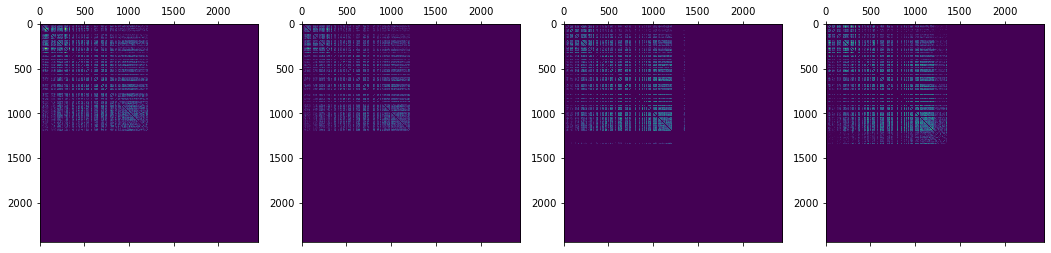

In [115]:
fig, ax = plt.subplots(1, 4, figsize=(18, 6))
for day in range(4):
    data = OneDayDataSet(day)
    ax[day].matshow(torch.Tensor(data.data.todense().astype(np.float32)).sum(0))
plt.show()

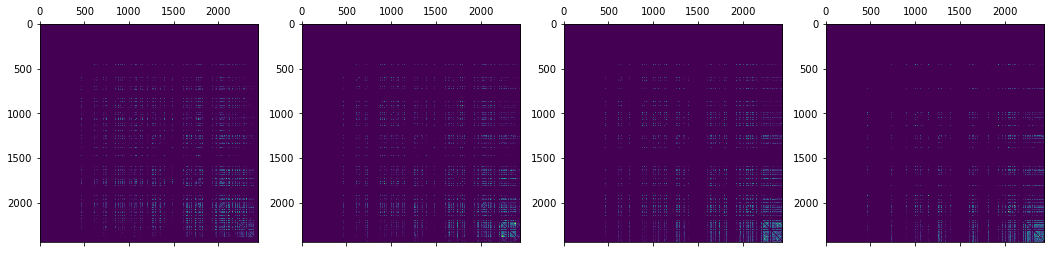

In [37]:
fig, ax = plt.subplots(1, 4, figsize=(18, 6))
for day in range(30, 34):
    data = OneDayDataSet(day)
    ax[day - 30].matshow(torch.Tensor(data.data.todense().astype(np.float32)).sum(0), cmap='viridis')
plt.show()

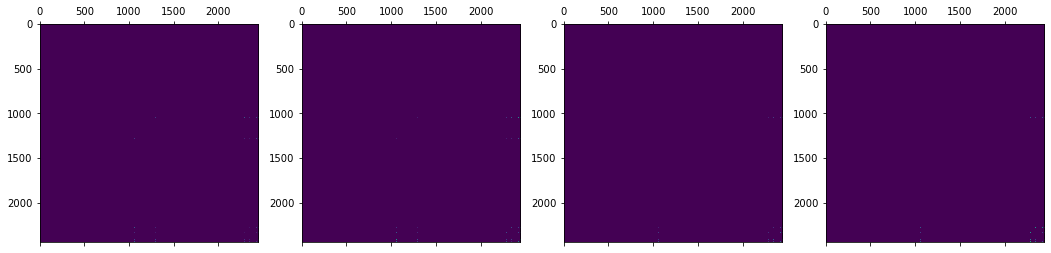

In [117]:
fig, ax = plt.subplots(1, 4, figsize=(18, 6))
for day in range(52, 56):
    data = OneDayDataSet(day)
    ax[day - 52].matshow(torch.Tensor(data.data.todense().astype(np.float32)).sum(0))
plt.show()

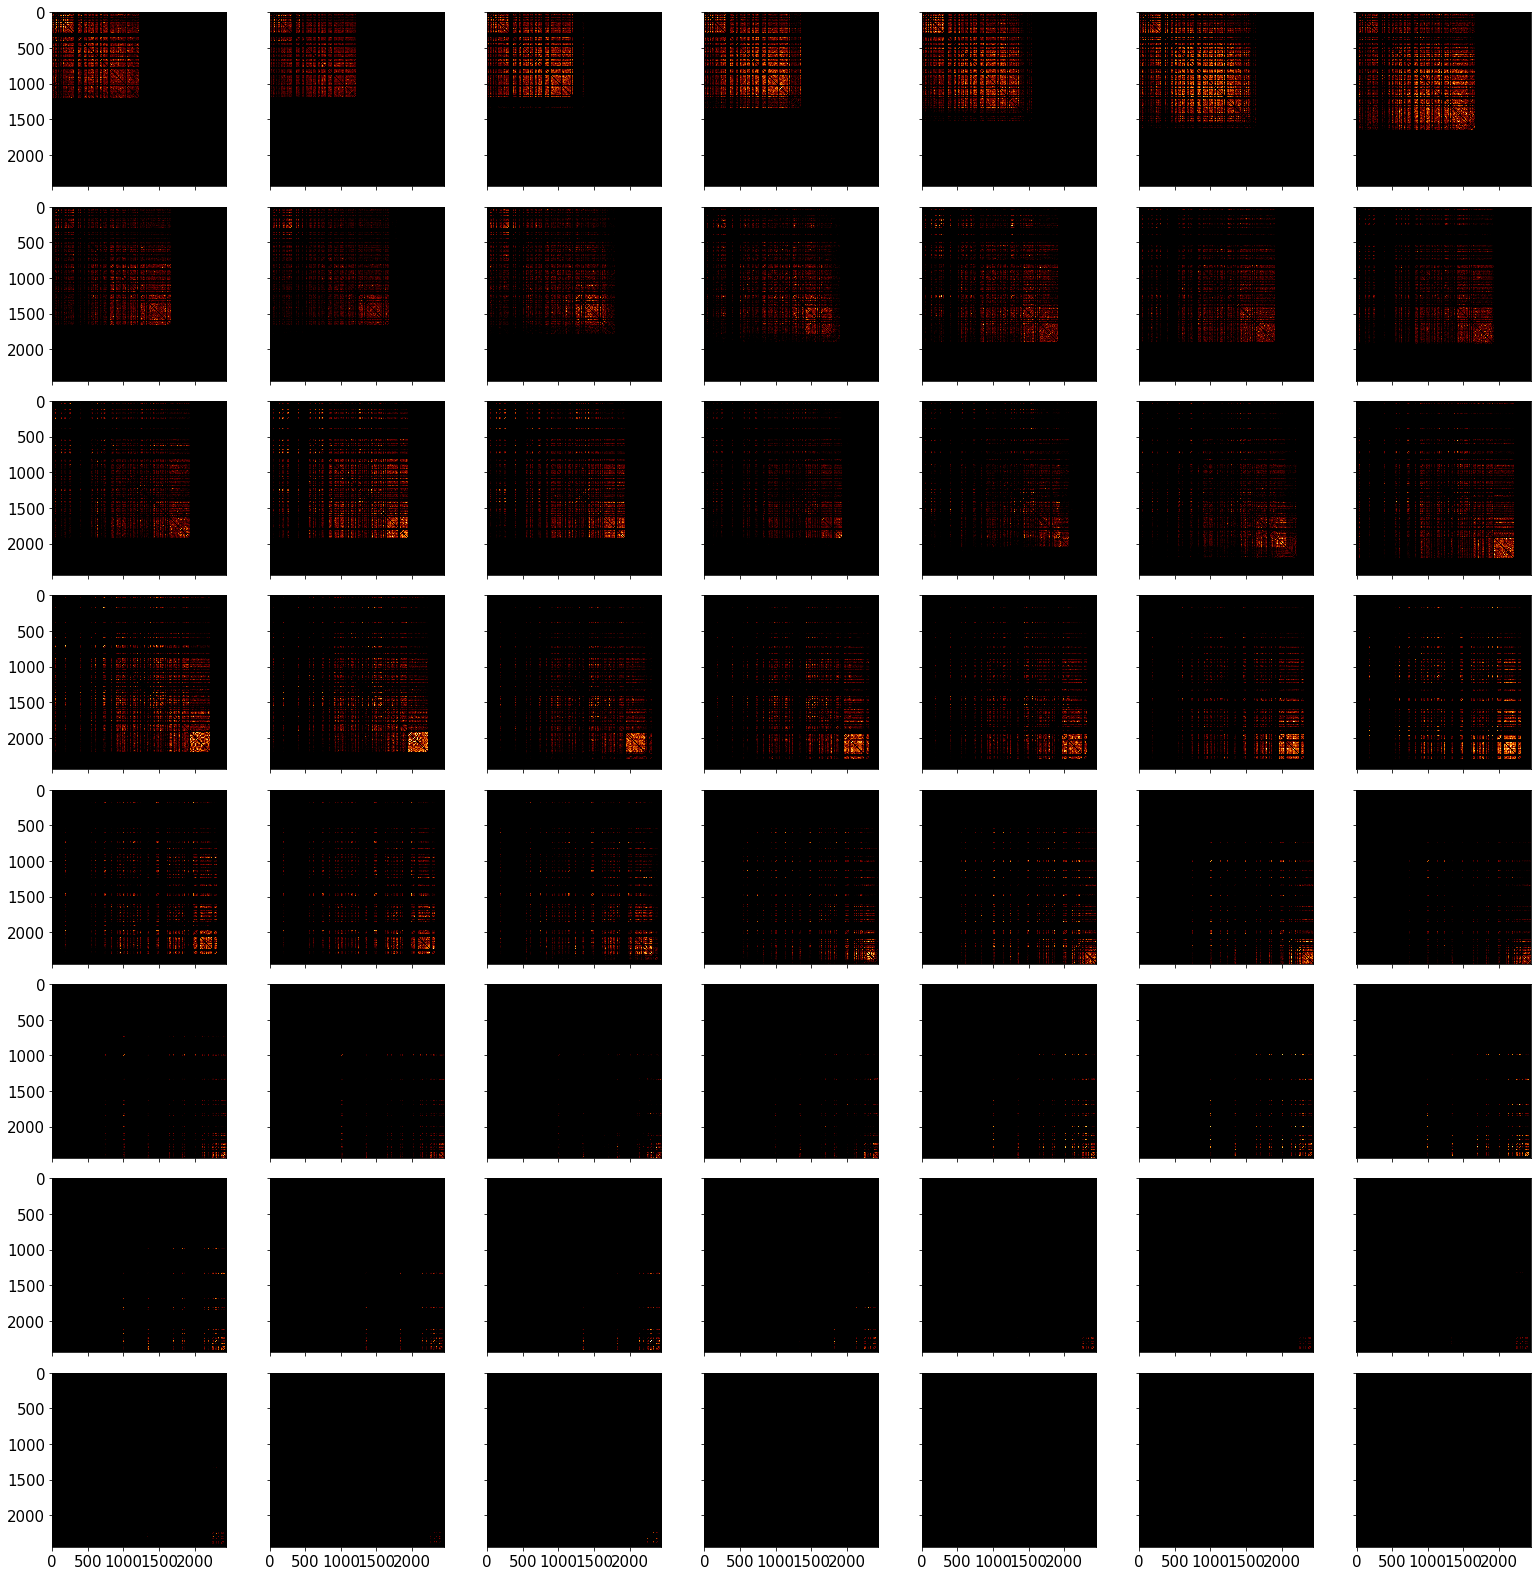

In [34]:
fig, ax = plt.subplots(8, 7, figsize=(22, 22))
for week in range(8):
    for day in range(7):
        data = OneDayDataSet(week * 7 + day)
        ax[week][day].matshow(torch.Tensor(data.data.todense().astype(np.float32)).sum(0)) #cmap='afmhot'
#         ax[week][day].matshow(torch.zeros((2443, 2443)))
        ax[week][day].tick_params(axis='both', labelcolor='none', labelsize=0,
                                  top=False, bottom=True, left=True, right=False,
                                  labeltop=False, labelbottom=False, labelleft=False, labelright=False)
        
for i in range(8):
    ax[i][0].tick_params(axis='both', left=True, labelleft=True, labelcolor='black', labelsize=15)
for i in range(7):
    ax[-1][i].tick_params(axis='both', bottom=True, labelbottom=True, labelcolor='black', labelsize=15)

# plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.001, hspace=.1)
plt.tight_layout()
plt.show()

### Individual view over time

In [68]:
%matplotlib inline
#@interact(x=ipywidgets.IntSlider(min=-0, max=48, step=1, value=0))
def time_slider(x, y):
    fig = plt.figure(figsize=(6, 6))
    #plt.matshow(IndividualDataSet(x).data[y].todense().astype(np.float32), fignum=1)
    plt.scatter(np.arange(2443), IndividualDataSet(x).data[y].todense().astype(np.float32))
    plt.show()
interactive_plot = interactive(time_slider, x=ipywidgets.IntSlider(min=0, max=2443, step=1, value=0, continuous_update=False), y=ipywidgets.IntSlider(min=0, max=2688, step=1, value=0, continuous_update=False))
output = interactive_plot.children[-1]
output.layout.height = '370px'
interactive_plot

interactive(children=(IntSlider(value=0, continuous_update=False, description='x', max=2443), IntSlider(value=…

### Split & Loaders

In [32]:
# first 36 days
bn16_data = Bn16DataSet(days=(0, 35))
len(bn16_data)

2443

In [83]:
# 80/20 split
train_data, test_data = random_split(bn16_data, [1955, 488])

full_loader = DataLoader(
    bn16_data
    ,batch_size=BATCH_SIZE
    ,shuffle=False
    ,num_workers=4
    ,drop_last=True
)
train_loader = DataLoader(
    train_data
    ,batch_size=BATCH_SIZE
    ,shuffle=False
    ,num_workers=4
    ,drop_last=True
)
test_loader = DataLoader(
    test_data
    ,batch_size=BATCH_SIZE
    ,shuffle=False
    ,num_workers=2
    ,drop_last=True
)

In [18]:
for idx, (x, y) in enumerate(train_loader):
    print(idx, x.shape, y)
    break

0 torch.Size([8, 1680, 2443]) {'lifespan': tensor([[ 143.,  142.,  141.,  ...,    0.,    0.,    0.],
        [   0.,    0.,    0.,  ...,    0.,    0.,    0.],
        [   0.,    0.,    0.,  ...,    0.,    0.,    0.],
        ...,
        [1775., 1774., 1773.,  ...,    0.,    0.,    0.],
        [   0.,    0.,    0.,  ...,    0.,    0.,    0.],
        [   0.,    0.,    0.,  ...,    0.,    0.,    0.]], dtype=torch.float64)}


In [19]:
import gc
gc.collect()

22

validate rewrite of R²

In [91]:
def center1(y, y_pred):
    mean = np.mean(y)
    return 1 - (np.sum(np.power(y_pred - y, 2)) / np.sum((y - mean) ** 2))

In [115]:
def center2(y, y_pred):
    return 1 - np.sum(np.power(y_pred - y, 2)) / (np.sum(np.power(y, 2)) - (np.sum(y) ** 2) / len(y))

In [117]:
a = (np.array([1,2,0,10,5,3]), np.array([3,2,1,1,9,4]))

print(center1(*a))
print(center2(*a))

-0.5725190839694656
-0.5725190839694656


## Graph stuff

In [53]:
bn16_data[1][0]

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

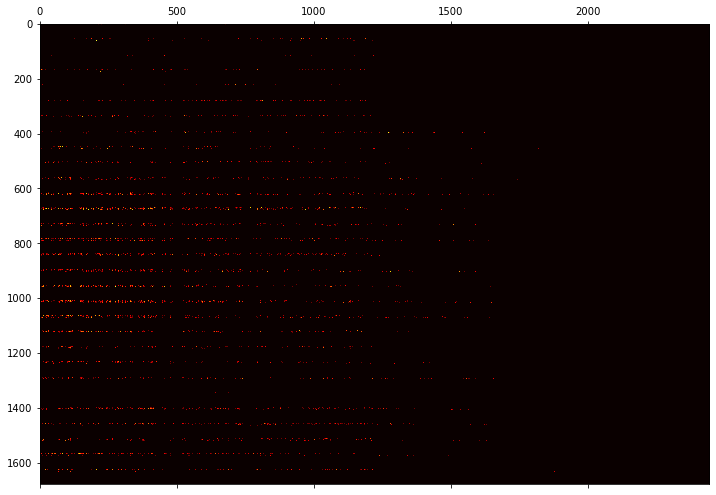

In [52]:
fig, ax = plt.subplots(figsize=(12, 12))
ax.matshow(bn16_data[1][0], cmap='hot')
plt.show()

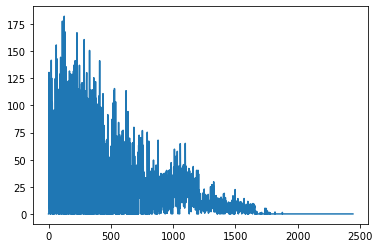

In [57]:
# summed edges for bee 1
plt.plot(bn16_data[1][0].sum(axis=0))
plt.show()

In [58]:
# total edges
np.count_nonzero(bn16_data[1][0].sum(axis=0))

1364

In [74]:
# avg edges
print(bn16_data[1][0].shape)
np.count_nonzero(bn16_data[1][0], axis=1).mean()

torch.Size([1680, 2443])


21.248214285714287

In [70]:
# avg edges while alive
per_time = np.count_nonzero(bn16_data[1][0], axis=1)
per_time[per_time != 0].mean()

128.4064748201439

now for the whole hive

In [128]:
avg_edges = []
avg_edges_alive = []
for idx, (x, y) in enumerate(full_loader):
    # x: batch x time x ind
    batch_per_time = np.count_nonzero(x, axis=2) # batch x edges per timestep, 8x1680
    avg_edges.append(batch_per_time.mean(axis=1).sum() / 8) # avg along edges per timestep, sum over batch
    mask = ~np.ma.masked_equal(batch_per_time, 0).mask # batch x time - truthy where != 0
    avg_edges_alive.append(batch_per_time[mask].mean())

In [129]:
print(np.array(avg_edges).mean())
print(np.array(avg_edges_alive).mean())

41.966347336065574
170.02490608587962


In [ ]:
# total sparsity
data = sparse.load_npz('bn16_intraday.npz')
print(data.nnz)
print(data.size)
print(data.density)
print(data)

In [155]:
bn16_data = OneDayDataSet(1)
bn16_data[0].shape

torch.Size([2443, 2443])

In [170]:
bn16_data[0][1][:100]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0986, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 1.3867, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 2.1973, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 2.3027, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        2.9961, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0986,
        0.0000], dtype=torch.float16)

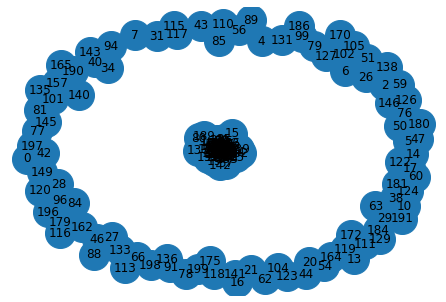

In [161]:
adj = bn16_data[0][:200,:200]

rows, cols = np.where(adj != 0)
edges = zip(rows.tolist(), cols.tolist())
gr = nx.Graph()
all_rows = range(0, adj.shape[0])
for n in all_rows:
    gr.add_node(n)
gr.add_edges_from(edges)
nx.draw(gr, node_size=900, with_labels=True)
plt.show()

In [71]:
# 348
mid = 348
bee_id = matrix_id_to_bee_id(348)
print(mid, bee_id)

circadian[circadian['bee_id'] == bee_id]

348 843


,bee_id,age,date,circadian_rhythmicity
1077,843,9,2016-07-28,0.069785
2240,843,10,2016-07-29,0.031600
3447,843,11,2016-07-30,0.037513
4628,843,12,2016-07-31,0.069691
5771,843,13,2016-08-01,0.112172
7001,843,14,2016-08-02,0.069021
8330,843,15,2016-08-03,0.072374
9631,843,16,2016-08-04,0.083459
10891,843,17,2016-08-05,0.156677
12136,843,18,2016-08-06,0.236532


In [72]:
combined_alive_data[combined_alive_data['interaction_matrix_idx'] == mid]

,bee_id,date_emerged,days_alive,interaction_matrix_idx,born_in_step,dead_by_step
348,843,2016-07-19,43,348,-192,1872


In [30]:
combined_alive_data[combined_alive_data['bee_id'] == 843]

,bee_id,date_emerged,days_alive,interaction_matrix_idx,born_in_step,dead_by_step
346,843,2016-07-19,43,346,-192,1872


In [20]:
### influence

In [21]:
most_influential = [610,901,1033,1405,1443,1747,1936,1972,1987,2030,2034,2101,2108,2118,2125,2131,2163,2190,2192,2213,2247,2389,2512,2786,2792,2942,3112,3132,3184]

In [26]:
combined_alive_data[combined_alive_data['bee_id'].isin(most_influential)]

,bee_id,date_emerged,days_alive,interaction_matrix_idx,born_in_step,dead_by_step
222,610,2016-07-19,9,222,-192,240
387,901,2016-07-19,9,387,-192,240
461,1033,2016-07-19,6,461,-192,96
749,1405,2016-07-19,6,749,-192,96
781,1443,2016-07-19,6,781,-192,96
1056,1747,2016-07-21,5,1056,-96,144
1220,1936,2016-07-26,10,1220,144,624
1255,1972,2016-07-26,9,1255,144,576
1267,1987,2016-07-26,11,1267,144,672
1308,2030,2016-07-26,15,1308,144,864


In [32]:
combined_alive_data[combined_alive_data['bee_id'].isin(most_influential)]['days_alive'].mean()

10.655172413793103

In [34]:
circadian[circadian['bee_id'].isin(most_influential)]['circadian_rhythmicity'].mean()

0.07046651029519158

In [35]:
np.abs(circadian[circadian['bee_id'].isin(most_influential)]['circadian_rhythmicity']).mean()

0.07046651029535762

In [37]:
circadian['circadian_rhythmicity'].mean()

0.0783725138975603